In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import pickle as pkl
import pulp

import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt

In [2]:
from haplm.lm_dist import LatentMult, find_4ti2_prefix
from haplm.hap_util import num_to_str, str_to_num, mat_by_marker
from haplm.gp_util import GP

In [3]:
from matplotlib import rc, rcParams
rc('font', **{'family': 'serif', 'serif': ['Palatino']})
rc('text', usetex = True)
rc('font', size=14)

# colors for plotting
colors = [
    '#1b9e77',
    '#d95f02',
    '#7570b3',
    '#e7298a',
    '#66a61e',
    '#e6ab02'
]

In [4]:
H = 8
N = 30 # number of data points
pool_size = 50
n_markers = 3
amat = mat_by_marker(n_markers)

In [5]:
with open('../../data/time-series/sim_data.pkl', 'rb') as fp:
    tmp = pkl.load(fp)
    p_true = tmp['p'] # H x T
    zs_true = tmp['z'] # N x H

In [6]:
t_obs = []
ns = []
ys = []
with open('../../data/time-series/time-series.data') as fp:
    for line in fp:
        tokens = line.split()
        t_obs.append(float(tokens[0]))
        ns.append(int(tokens[1]))
        ys.append(np.array([int(x) for x in tokens[2:]]))
t_obs = np.array(t_obs)

In [7]:
idata_exact = az.from_netcdf('../../data/time-series/psize50_m3_exact.netcdf')
idata_mn = az.from_netcdf('../../data/time-series/psize50_m3_mn_approx.netcdf')
idata_gibbs = az.from_netcdf(f'../../data/time-series/psize50_m3_gibbs.netcdf')

In [8]:
ess_exact = az.ess(idata_exact, var_names=['p'])['p'].values
lowhaps = np.argsort(ess_exact.flatten())
for h in lowhaps[:30]:
    print(round(ess_exact[h//8,h%8]), h//8, h%8)

364 15 4
389 16 4
394 17 4
395 15 6
396 14 4
407 17 5
409 15 5
409 16 6
411 18 4
414 16 5
414 19 5
416 18 5
422 15 7
427 18 6
430 16 7
434 19 6
434 13 4
436 14 6
439 17 7
447 17 6
450 20 6
452 18 7
455 14 5
461 13 6
462 19 4
462 14 7
475 19 7
481 20 5
499 21 6
521 20 7


In [9]:
ess_mn = az.ess(idata_mn, var_names=['p'])['p'].values
lowhaps = np.argsort(ess_mn.flatten())
for h in lowhaps[:30]:
    print(round(ess_mn[h//8,h%8]), h//8, h%8)

488 16 5
492 15 5
493 16 4
494 15 4
501 18 5
508 19 5
513 15 6
513 17 5
526 17 7
530 18 4
535 16 6
536 15 7
540 14 4
542 18 7
545 16 7
546 17 4
555 19 4
562 19 7
570 14 6
570 14 5
577 18 6
581 19 6
585 17 6
587 20 5
607 13 4
620 14 7
622 13 6
624 20 7
639 20 6
678 20 4


In [10]:
ess_gibbs = az.ess(idata_gibbs, var_names=['p'])['p'].values
lowhaps = np.argsort(ess_gibbs.flatten())
for h in lowhaps[:30]:
    print(round(ess_gibbs[h//8,h%8]), h//8, h%8)

144 17 5
146 18 5
148 21 5
153 16 5
156 20 5
156 19 5
158 15 5
158 14 5
167 15 4
172 13 5
173 19 7
176 15 6
177 16 4
181 14 4
181 22 5
181 15 7
182 16 7
183 17 4
183 18 4
183 18 7
184 16 6
188 13 4
191 17 6
191 14 6
194 17 7
198 19 4
198 18 6
199 19 6
202 14 7
203 12 5


In [11]:
idata_gibbs.sample_stats.diverging.values.sum(axis=1)

array([0, 1, 0, 2, 0])

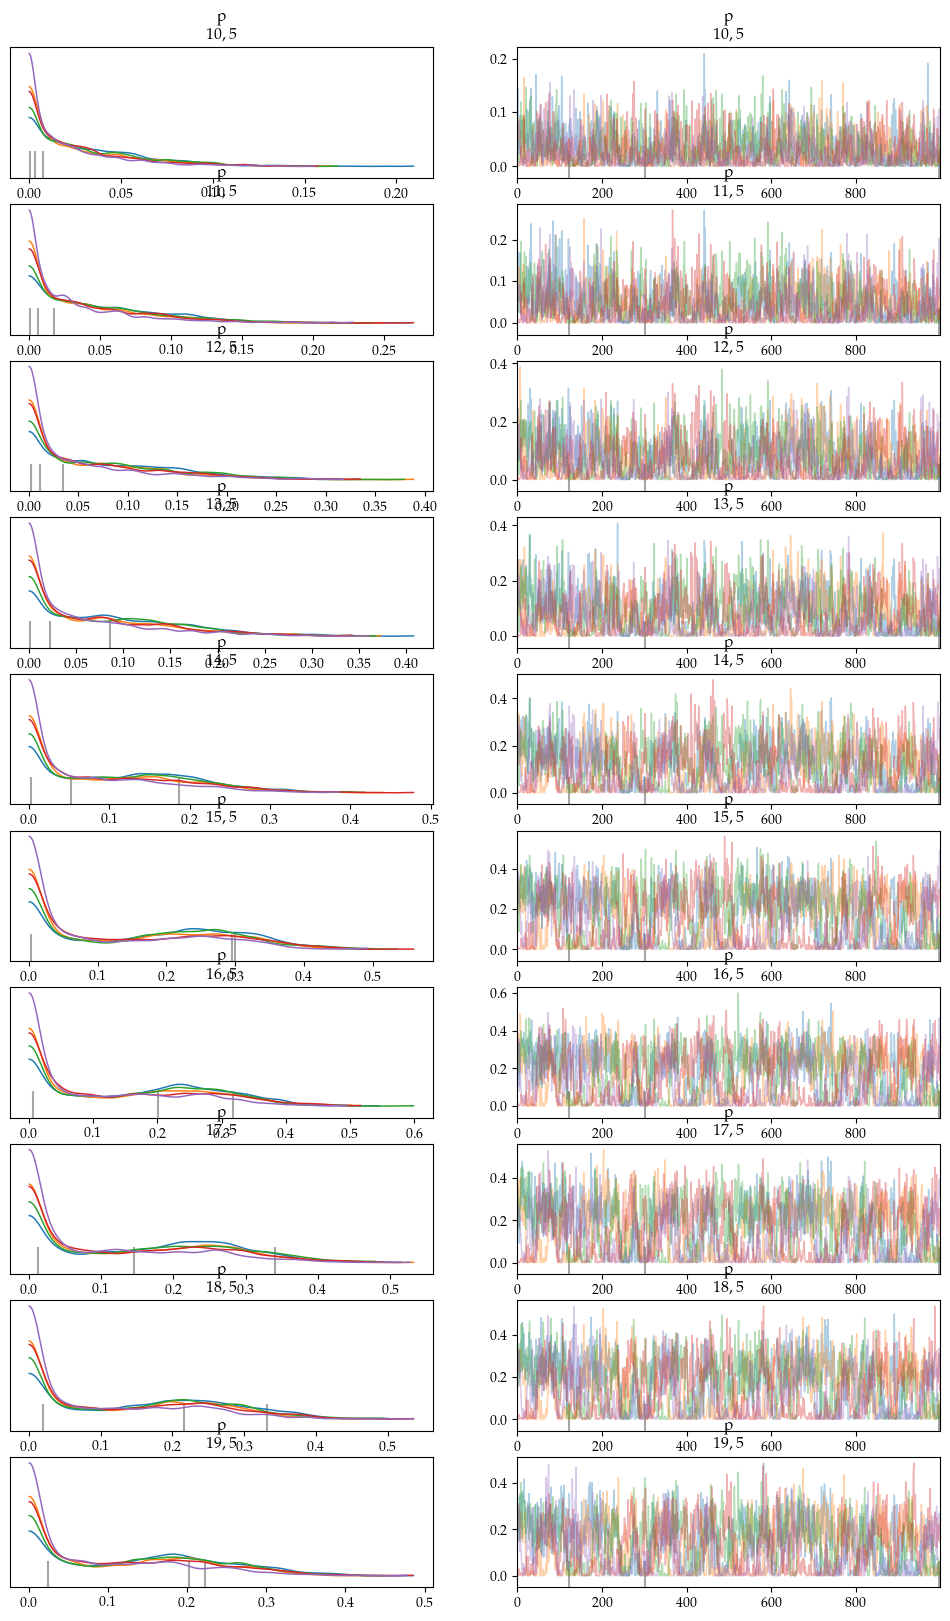

In [12]:
az.plot_trace(idata_gibbs, var_names=['p'], coords={'p_dim_1':[5], 'p_dim_0':np.arange(10,20)}, compact=False);

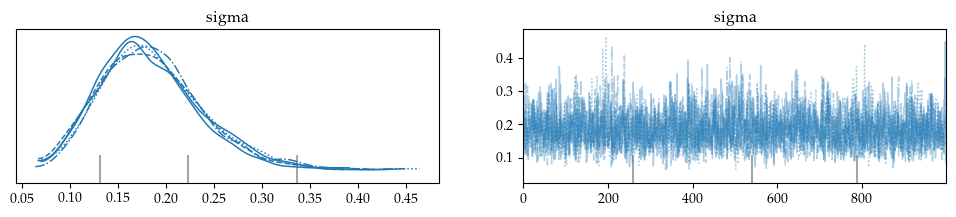

In [13]:
az.plot_trace(idata_exact, var_names=['sigma']);

In [14]:
for idata in [idata_exact, idata_mn, idata_gibbs]:
    print((idata.sample_stats.attrs['preprocess_time'] + idata.sample_stats.attrs['mcmc_walltime'])/60)

90.28063633441926
5.874797356128693
33.23189251422882


In [8]:
pess_exact = az.ess(idata_exact, var_names=['p'])['p'].values.flatten()
pess_gibbs = az.ess(idata_gibbs, var_names=['p'])['p'].values.flatten()
pess_mn = az.ess(idata_mn, var_names=['p'])['p'].values.flatten()

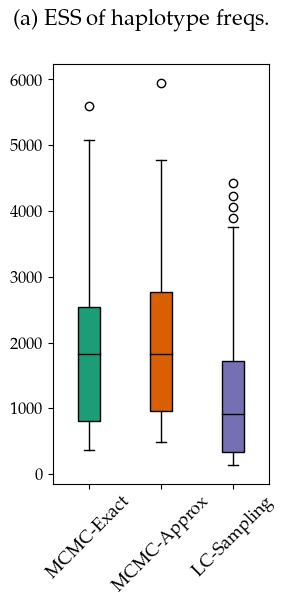

In [16]:
fig = plt.figure(figsize=(3, 6))
boxp = plt.boxplot([pess_exact, pess_mn, pess_gibbs], labels=['MCMC-Exact', 'MCMC-Approx', 'LC-Sampling'],
                   patch_artist=True, medianprops=dict(color='k'))
for patch, color in zip(boxp['boxes'], colors[:3]):
    patch.set_facecolor(color)
plt.xticks(rotation=45)
plt.tick_params(axis='x', which='both', labelsize=13)
plt.tick_params(axis='y', which='both', labelsize=12)
fig.suptitle(r'(a) ESS of haplotype freqs.', fontsize=16, y=0.97)
plt.subplots_adjust(top=0.88, left=0.2, right=0.92, bottom=0.18);
plt.savefig(f'ts_ess.png', dpi=200, facecolor='white'); 

In [10]:
with open(f'../../data/time-series/psize50_m3_exact_sumstats.pkl', 'rb') as fp:
    sumstats_exact = pkl.load(fp)

with open(f'../../data/time-series/psize50_m3_mn_approx_sumstats.pkl', 'rb') as fp:
    sumstats_mn = pkl.load(fp)
    
with open(f'../../data/time-series/psize50_m3_gibbs_sumstats.pkl', 'rb') as fp:
    sumstats_gibbs = pkl.load(fp)

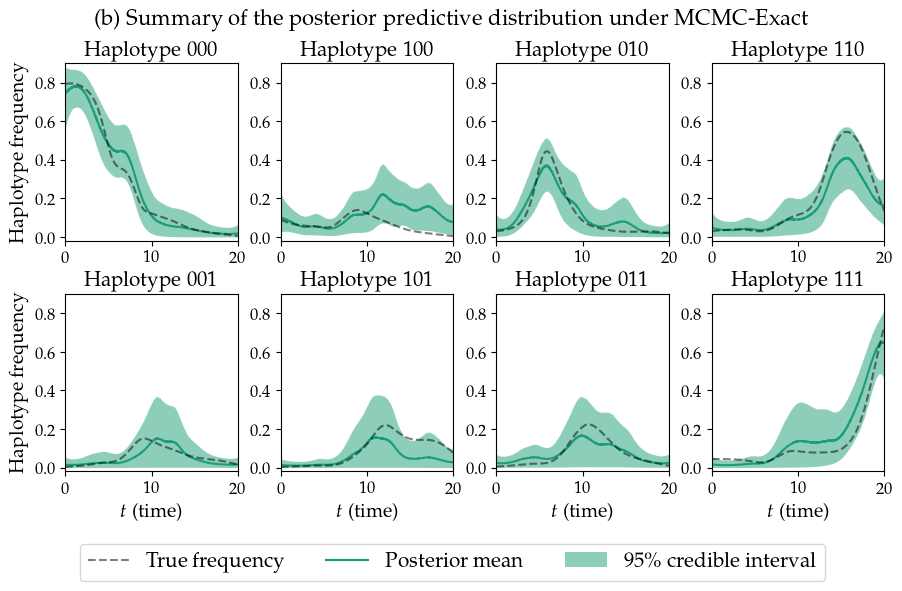

In [18]:
ts = np.arange(0, 20.00001, 0.001)
t_pred = np.arange(0, 20.001, 0.01)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 6))
for i in range(H):
    ax = axes[i//4][i%4]   
    ax.fill_between(t_pred,
                    sumstats_exact['quantiles'][1,:,i],
                    sumstats_exact['quantiles'][-2,:,i],
                    color=colors[0], alpha=0.5, linewidth=0, label='95\% credible interval')
    ax.plot(t_pred, sumstats_exact['mean'][:,i], color=colors[0], alpha=1, label='Posterior mean')
    ax.plot(ts, p_true[i], '--', color='k', alpha=0.5, label='True frequency')
    #ax.set_yscale('log')
    ax.set_ylim(-0.02, 0.9)
    ax.set_xlim(0, 20)
    if i // 4 == 1:
        ax.set_xticks(np.arange(0, 21, 10))
        ax.set_xlabel('$t$ (time)', fontsize=14)
    else:
        ax.set_xticks(np.arange(0, 21, 10))
    if i % 4 == 0:
        ax.set_ylabel(f'Haplotype frequency', fontsize=14)
    else:
        ax.set_yticks(np.arange(0, 0.81, 0.2))
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_title(f'Haplotype {num_to_str(i, 3)}', fontsize=15)

fig.suptitle('(b) Summary of the posterior predictive distribution under MCMC-Exact', fontsize=16, y=0.97)
handles, labels = ax.get_legend_handles_labels()
labels = labels[::-1]
handles = handles[::-1]
fig.legend(handles, labels, loc='lower center', ncols=len(labels), bbox_to_anchor=(0.5, 0), fontsize=15);

fig.subplots_adjust(top=0.88, bottom=0.2, left=0.07, right=0.98, wspace=0.25, hspace=0.3)
plt.savefig(f'ts_exact_trends.png', dpi=200, facecolor='white');

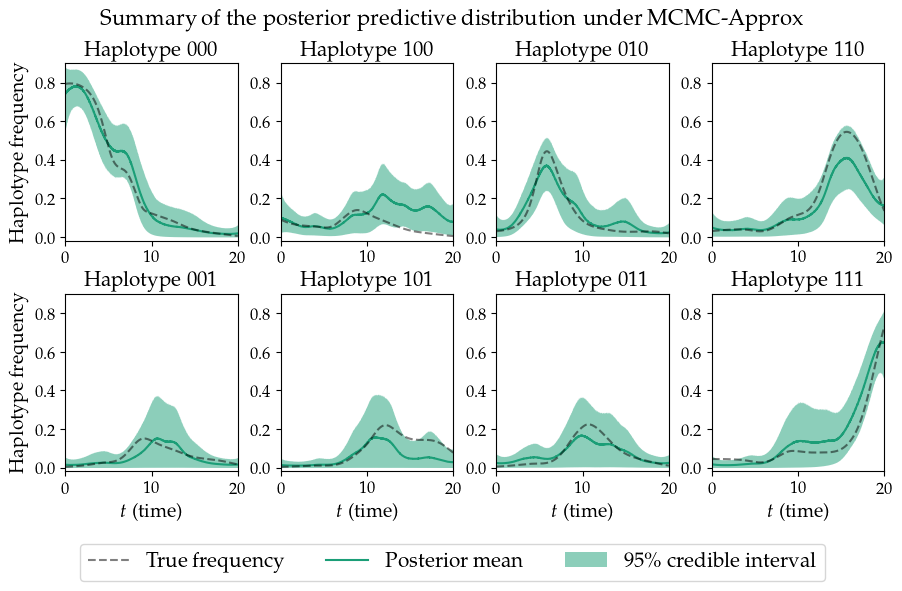

In [19]:
ts = np.arange(0, 20.00001, 0.001)
t_pred = np.arange(0, 20.001, 0.01)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 6))
for i in range(H):
    ax = axes[i//4][i%4]   
    ax.fill_between(t_pred,
                    sumstats_mn['quantiles'][1,:,i],
                    sumstats_mn['quantiles'][-2,:,i],
                    color=colors[0], alpha=0.5, linewidth=0, label='95\% credible interval')
    ax.plot(t_pred, sumstats_exact['mean'][:,i], color=colors[0], alpha=1, label='Posterior mean')
    ax.plot(ts, p_true[i], '--', color='k', alpha=0.5, label='True frequency')
    #ax.set_yscale('log')
    ax.set_ylim(-0.02, 0.9)
    ax.set_xlim(0, 20)
    if i // 4 == 1:
        ax.set_xticks(np.arange(0, 21, 10))
        ax.set_xlabel('$t$ (time)', fontsize=14)
    else:
        ax.set_xticks(np.arange(0, 21, 10))
    if i % 4 == 0:
        ax.set_ylabel(f'Haplotype frequency', fontsize=14)
    else:
        ax.set_yticks(np.arange(0, 0.81, 0.2))
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_title(f'Haplotype {num_to_str(i, 3)}', fontsize=15)

fig.suptitle('Summary of the posterior predictive distribution under MCMC-Approx', fontsize=16, y=0.97)
handles, labels = ax.get_legend_handles_labels()
labels = labels[::-1]
handles = handles[::-1]
fig.legend(handles, labels, loc='lower center', ncols=len(labels), bbox_to_anchor=(0.5, 0), fontsize=15);

fig.subplots_adjust(top=0.88, bottom=0.2, left=0.07, right=0.98, wspace=0.25, hspace=0.3)
plt.savefig(f'ts_mn_trends.png', dpi=200, facecolor='white');

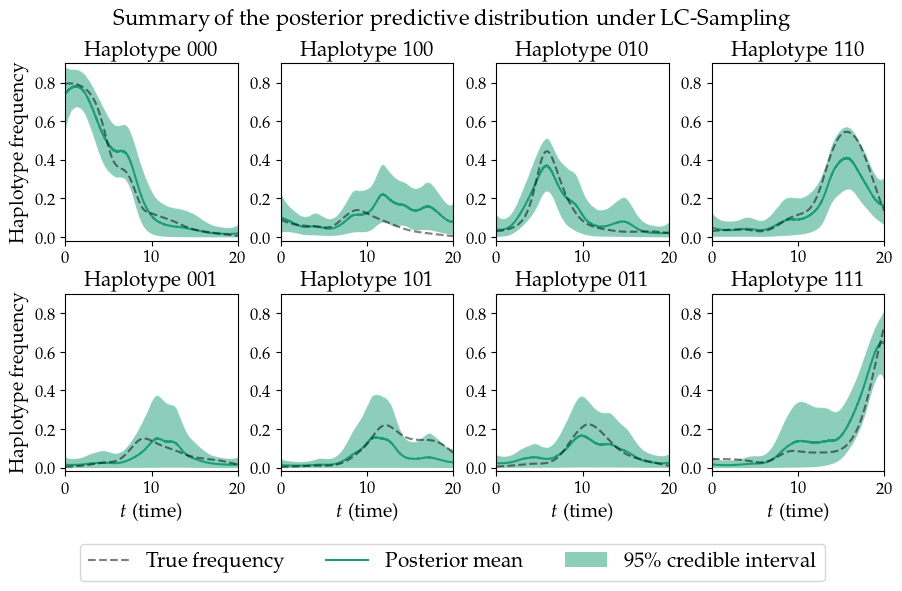

In [20]:
ts = np.arange(0, 20.00001, 0.001)
t_pred = np.arange(0, 20.001, 0.01)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 6))
for i in range(H):
    ax = axes[i//4][i%4]   
    ax.fill_between(t_pred,
                    sumstats_gibbs['quantiles'][1,:,i],
                    sumstats_gibbs['quantiles'][-2,:,i],
                    color=colors[0], alpha=0.5, linewidth=0, label='95\% credible interval')
    ax.plot(t_pred, sumstats_exact['mean'][:,i], color=colors[0], alpha=1, label='Posterior mean')
    ax.plot(ts, p_true[i], '--', color='k', alpha=0.5, label='True frequency')
    #ax.set_yscale('log')
    ax.set_ylim(-0.02, 0.9)
    ax.set_xlim(0, 20)
    if i // 4 == 1:
        ax.set_xticks(np.arange(0, 21, 10))
        ax.set_xlabel('$t$ (time)', fontsize=14)
    else:
        ax.set_xticks(np.arange(0, 21, 10))
    if i % 4 == 0:
        ax.set_ylabel(f'Haplotype frequency', fontsize=14)
    else:
        ax.set_yticks(np.arange(0, 0.81, 0.2))
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_title(f'Haplotype {num_to_str(i, 3)}', fontsize=15)

fig.suptitle('Summary of the posterior predictive distribution under LC-Sampling', fontsize=16, y=0.97)
handles, labels = ax.get_legend_handles_labels()
labels = labels[::-1]
handles = handles[::-1]
fig.legend(handles, labels, loc='lower center', ncols=len(labels), bbox_to_anchor=(0.5, 0), fontsize=15);

fig.subplots_adjust(top=0.88, bottom=0.2, left=0.07, right=0.98, wspace=0.25, hspace=0.3)
plt.savefig(f'ts_gibbs_trends.png', dpi=200, facecolor='white');

In [12]:
exact_means = np.mean(np.vstack(idata_exact.posterior.p), axis=0)
exact_stds = np.std(np.vstack(idata_exact.posterior.p), axis=0)
gibbs_means = np.mean(np.vstack(idata_gibbs.posterior.p), axis=0)
gibbs_stds = np.std(np.vstack(idata_gibbs.posterior.p), axis=0)
mn_means = np.mean(np.vstack(idata_mn.posterior.p), axis=0)
mn_stds = np.std(np.vstack(idata_mn.posterior.p), axis=0)

In [22]:
np.abs(exact_means-gibbs_means).max()

0.003724773913980267

In [23]:
np.abs(exact_means-mn_means).max()

0.006468672632817141

In [24]:
np.abs(exact_stds-gibbs_stds).max()

0.003292648157869782

In [25]:
np.abs(exact_stds-mn_stds).max()

0.00354312318196974

In [11]:
exact_pred_tint = np.load(f'../../data/time-series/psize50_m3_exact_pred_samples_tint.npy')
mn_pred_tint = np.load(f'../../data/time-series/psize50_m3_mn_approx_pred_samples_tint.npy')
gibbs_pred_tint = np.load(f'../../data/time-series/psize50_m3_gibbs_pred_samples_tint.npy')

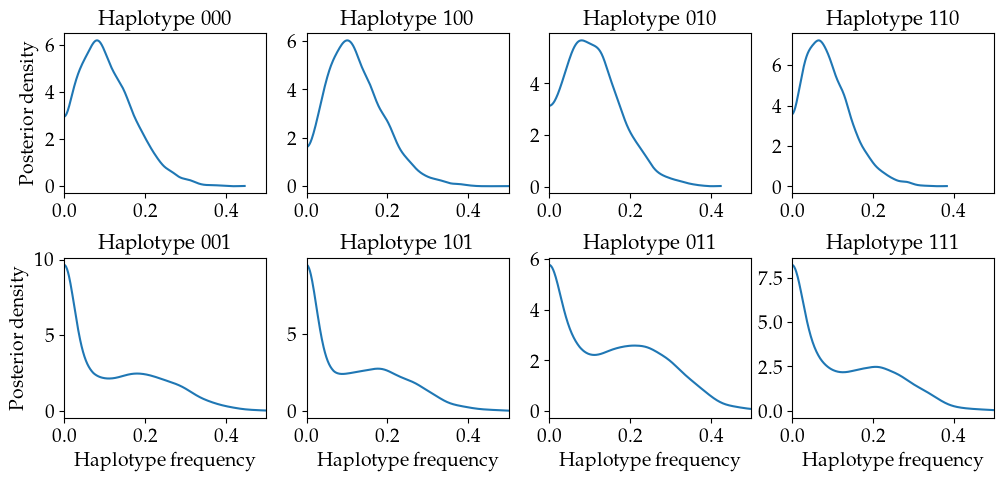

In [27]:
ts = np.arange(0, 20.00001, 0.001)
t_pred = np.arange(0, 20.001, 0.01)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 5))
for i in range(H):
    ax = axes[i//4][i%4]   
    grid, dens = az.stats.density_utils.kde(exact_pred_tint[:,10,i], bw='scott')
    ax.plot(grid, dens)
    ax.set_title(f'Haplotype {num_to_str(i, 3)}', fontsize=15)
    if i // 4 == 1:
        ax.set_xlabel('Haplotype frequency', fontsize=14)
    if i % 4 == 0:
        ax.set_ylabel(f'Posterior density', fontsize=14)
    ax.set_xlim((0,0.5))
fig.subplots_adjust(hspace=0.4)

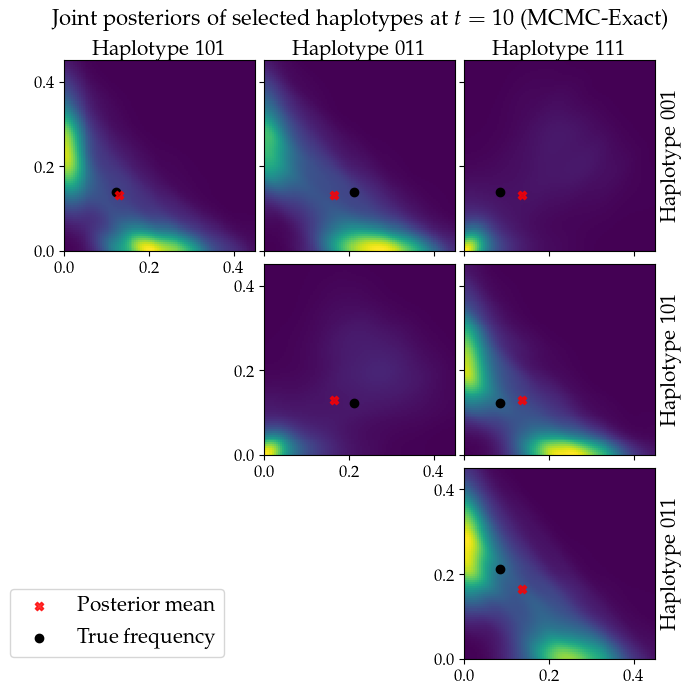

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12*0.6, 7))
gs = 128
for i in range(3):
    for j in range(i,3):
        h1, h2 = 4+i, 5+j
        ax = axes[i,j]
        v1, v2 = exact_pred_tint[:,10,h1], exact_pred_tint[:,10,h2]
        grid, xmin, xmax, ymin, ymax = az.stats.density_utils._fast_kde_2d(v2, v1, (gs, gs))
        x_x, y_y = np.mgrid[xmin:xmax+1e-9:(xmax-xmin)/(gs-1), ymin:ymax+1e-9:(ymax-ymin)/(gs-1)]
        ax.pcolormesh(x_x, y_y, grid);
        
        ax.scatter(sumstats_exact['mean'][1000,h2], sumstats_exact['mean'][1000,h1],
                   color='r', alpha=0.8, marker='X', label='Posterior mean', zorder=100)
        ax.scatter(p_true[h2,10000],p_true[h1,10000], 
                   color='k', label='True frequency', zorder=99)
        
        # ax.plot(p_true[h2,:],p_true[h1,:], '--', color='k')
        ax.set_xlim((0,0.45))
        ax.set_ylim((0,0.45))
        ax.set_aspect('equal')
       
        if j == 2:
            ax.yaxis.set_label_position('right')
            ax.set_ylabel(f'Haplotype {num_to_str(h1, 3)}', fontsize=15)
        if i == 0:
            ax.xaxis.set_label_position('top')
            ax.set_xlabel(f'Haplotype {num_to_str(h2, 3)}', fontsize=15)
        if i != j:
            ax.set_xticks([0,0.2,0.4], ['']*3)
            ax.set_yticks([0,0.2,0.4], ['']*3)
        else:
            ax.set_xticks([0,0.2,0.4])
            ax.set_yticks([0,0.2,0.4])            
        ax.tick_params(axis='both', which='both', labelsize=12)
fig.delaxes(axes[1,0]);
fig.delaxes(axes[2,0]);
fig.delaxes(axes[2,1]);

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0, 0.04), fontsize=15);
fig.suptitle('Joint posteriors of selected haplotypes at $t=10$ (MCMC-Exact)', fontsize=16)
fig.subplots_adjust(top=0.91, bottom=0.05, left=0.09, right=0.91, wspace=0.05, hspace=0.05)
plt.savefig(f'ts_exact_joint_t10.png', dpi=200, facecolor='white');

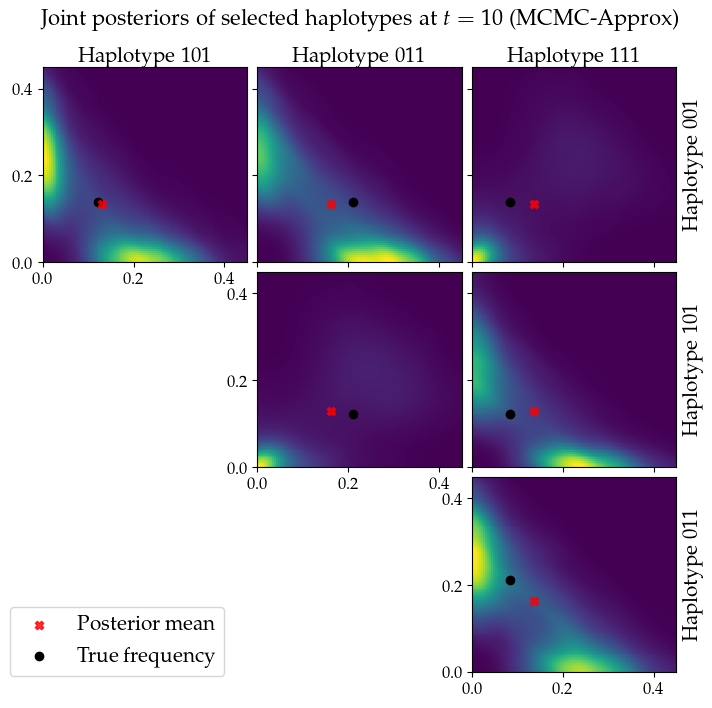

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12*0.6, 12*0.6))
gs = 128
for i in range(3):
    for j in range(i,3):
        h1, h2 = 4+i, 5+j
        ax = axes[i,j]
        v1, v2 = mn_pred_tint[:,10,h1], mn_pred_tint[:,10,h2]
        grid, xmin, xmax, ymin, ymax = az.stats.density_utils._fast_kde_2d(v2, v1, (gs, gs))
        x_x, y_y = np.mgrid[xmin:xmax+1e-9:(xmax-xmin)/(gs-1), ymin:ymax+1e-9:(ymax-ymin)/(gs-1)]
        ax.pcolormesh(x_x, y_y, grid);
        
        ax.scatter(sumstats_mn['mean'][1000,h2], sumstats_mn['mean'][1000,h1],
                   color='r', alpha=0.8, marker='X', label='Posterior mean', zorder=100)
        ax.scatter(p_true[h2,10000],p_true[h1,10000], 
                   color='k', label='True frequency', zorder=99)
        
        # ax.plot(p_true[h2,:],p_true[h1,:], '--', color='k')
        ax.set_xlim((0,0.45))
        ax.set_ylim((0,0.45))
        ax.set_aspect('equal')
        
        if j == 2:
            ax.yaxis.set_label_position('right')
            ax.set_ylabel(f'Haplotype {num_to_str(h1, 3)}', fontsize=15)
        if i == 0:
            ax.xaxis.set_label_position('top')
            ax.set_xlabel(f'Haplotype {num_to_str(h2, 3)}', fontsize=15)
        if i != j:
            ax.set_xticks([0,0.2,0.4], ['']*3)
            ax.set_yticks([0,0.2,0.4], ['']*3)
        else:
            ax.set_xticks([0,0.2,0.4])
            ax.set_yticks([0,0.2,0.4])            
        ax.tick_params(axis='both', which='both', labelsize=12)
fig.delaxes(axes[1,0]);
fig.delaxes(axes[2,0]);
fig.delaxes(axes[2,1]);

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0, 0.04), fontsize=15);
fig.suptitle('Joint posteriors of selected haplotypes at $t=10$ (MCMC-Approx)', fontsize=16)
fig.subplots_adjust(top=0.91, bottom=0.05, left=0.09, right=0.91, wspace=0.05, hspace=0.05)
plt.savefig(f'ts_mn_joint_t10.png', dpi=200, facecolor='white');

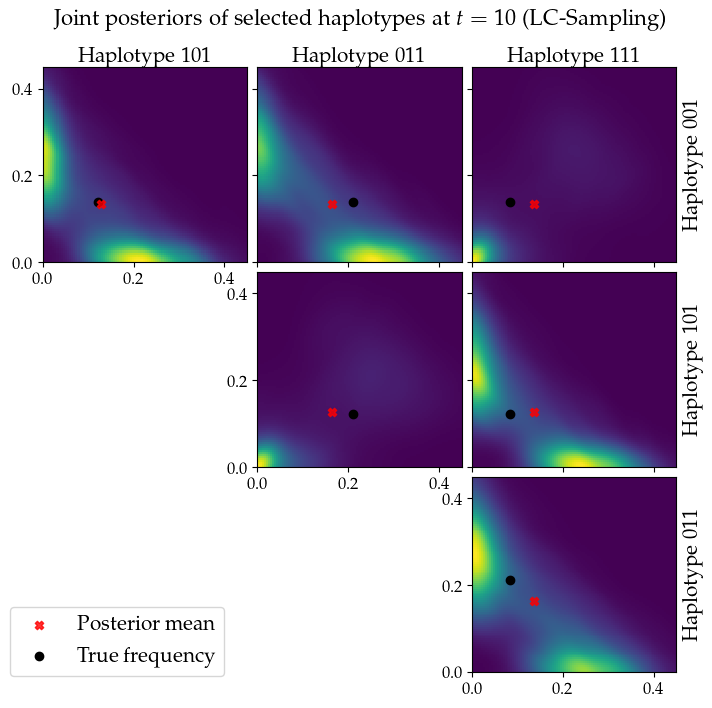

In [37]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12*0.6, 12*0.6))
gs = 128
for i in range(3):
    for j in range(i,3):
        h1, h2 = 4+i, 5+j
        ax = axes[i,j]
        v1, v2 = gibbs_pred_tint[:,10,h1], gibbs_pred_tint[:,10,h2]
        grid, xmin, xmax, ymin, ymax = az.stats.density_utils._fast_kde_2d(v2, v1, (gs, gs))
        x_x, y_y = np.mgrid[xmin:xmax+1e-9:(xmax-xmin)/(gs-1), ymin:ymax+1e-9:(ymax-ymin)/(gs-1)]
        ax.pcolormesh(x_x, y_y, grid);
        
        ax.scatter(sumstats_gibbs['mean'][1000,h2], sumstats_gibbs['mean'][1000,h1],
           color='r', alpha=0.8, marker='X', label='Posterior mean', zorder=100)
        ax.scatter(p_true[h2,10000],p_true[h1,10000], 
                   color='k', label='True frequency', zorder=99)
        
        # ax.plot(p_true[h2,:],p_true[h1,:], '--', color='k')
        ax.set_xlim((0,0.45))
        ax.set_ylim((0,0.45))
        ax.set_aspect('equal')
            
        if j == 2:
            ax.yaxis.set_label_position('right')
            ax.set_ylabel(f'Haplotype {num_to_str(h1, 3)}', fontsize=15)
        if i == 0:
            ax.xaxis.set_label_position('top')
            ax.set_xlabel(f'Haplotype {num_to_str(h2, 3)}', fontsize=15)
        if i != j:
            ax.set_xticks([0,0.2,0.4], ['']*3)
            ax.set_yticks([0,0.2,0.4], ['']*3)
        else:
            ax.set_xticks([0,0.2,0.4])
            ax.set_yticks([0,0.2,0.4])            
        ax.tick_params(axis='both', which='both', labelsize=12)
fig.delaxes(axes[1,0]);
fig.delaxes(axes[2,0]);
fig.delaxes(axes[2,1]);

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0, 0.04), fontsize=15);
fig.suptitle('Joint posteriors of selected haplotypes at $t=10$ (LC-Sampling)', fontsize=16)
fig.subplots_adjust(top=0.91, bottom=0.05, left=0.09, right=0.91, wspace=0.05, hspace=0.05)
plt.savefig(f'ts_gibbs_joint_t10.png', dpi=200, facecolor='white');

In [33]:
plt.ioff();
for t in range(21):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
    gs = 128
    for i in range(3):
        for j in range(i,3):
            h1, h2 = 4+i, 5+j
            ax = axes[i,j]
            v1, v2 = exact_pred_tint[:,t,h1], exact_pred_tint[:,t,h2]
            grid, xmin, xmax, ymin, ymax = az.stats.density_utils._fast_kde_2d(v2, v1, (gs, gs))
            x_x, y_y = np.mgrid[xmin:xmax+1e-9:(xmax-xmin)/(gs-1), ymin:ymax+1e-9:(ymax-ymin)/(gs-1)]
            ax.pcolormesh(x_x, y_y, grid);

            ax.scatter(p_true[h2,t*1000],p_true[h1,t*1000], color='k')
            ax.plot(p_true[h2,:],p_true[h1,:], '--', color='k')
            if j == 2:
                ax.set_xlim((0,0.75))
            else:
                ax.set_xlim((0,0.4))
            ax.set_ylim((0,0.4))
            ax.set_xticks([0,0.2,0.4])
            ax.set_yticks([0,0.2,0.4])
            if j == 2:
                ax.yaxis.set_label_position('right')
                ax.set_ylabel(f'Haplotype {num_to_str(h1, 3)}', fontsize=15)
            if i == 0:
                ax.xaxis.set_label_position('top')
                ax.set_xlabel(f'Haplotype {num_to_str(h2, 3)}', fontsize=15)
            ax.set_facecolor('#440154')
    fig.delaxes(axes[1,0]);
    fig.delaxes(axes[2,0]);
    fig.delaxes(axes[2,1]);
    plt.savefig(f'joints/ts_exact_joint_t{t}.png', dpi=200, facecolor='white');
    plt.close('all')
plt.ion();

In [17]:
plt.ion();